# AIDR Final Project - Pilot project

The scope of this notebook is to offer an example of the end to end implementation of the final project. Some tips:\n",
* use shift+enter to run each cell\n",
* use ctrl+alt+o to optimize your imports\n",
* use ctrl+alt+l to arrange your code\n",
* ctrl+click on the name of a variable/library will take you to it\n",
* the easiest way to install a library is by going to Interpreter Settings -> Install (ctrl+alt+s to access Settings)\n",
* use ctrl+k to commit and select the file(s) you want to commit\n",
* use the number (#123456) of the corresponding GitHub issue in your commit message to link your commit to the issue\n",
* use ctrl+shift+k to push your commits

Outline
1. [Project setup](#setup)
2. [Data gathering](#gather)
3. [Database connection](#connect)
4. [Database population](#populate)
5. [Data preprocessing & transformation](#preprocess)
6. [Exploratory Data Analysis](#eda)

### 1. Project setup<a id="setup"></a>

In [106]:
# Library imports
import geopandas as gpd
import numpy as np
import json
import pandas as pd
import requests
import seaborn as sns
from pymongo import MongoClient
from unidecode import unidecode

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(20, 20))

In [153]:
# Mongo credentials
MONGO_USER = 'firstnameLastname'
MONGO_PASSWORD = 'student_id'
MONGO_CLUSTER = 'idar2022'

### 2. Data gathering<a id="gather"></a>

In [251]:
# Data gathering from files published on different platforms
url = "https://raw.githubusercontent.com/stefanacioban/covid_19_spatial_analysis/main/data/lhdi_interpolated.csv"
lhdi_df = pd.read_csv(url) # store the csv values in a pandas dataframe

In [252]:
lhdi_df.head()

,siruta,lhdi_2018_pred
0,153400.0,41.0
1,152314.0,40.0
2,151978.0,57.8
3,151709.0,39.9
4,155118.0,50.0


This dataset contains the Local Human Development Index for each Administrative Territorial Unit (ATU) in Romania ([Sandu, 2020](https://www.sciencedirect.com/science/article/pii/S221167532100066X?via%3Dihub#b25)). The index was predicted for all ATUs with a population of less than 1000 inhabitants using spatial interpolation methods. The SIRUTA code is a unique identifier for each ATU.

In [110]:
# Check the data types of each column
lhdi_df.dtypes

siruta            float64
lhdi_2018_pred    float64
dtype: object

In [220]:
# Store the endpoint in a new variable
endpoint = 'https://covid19.geo-spatial.org/api/dashboard/getCasesByCounty'
response = requests.get(endpoint)
response

In [234]:
covid_data = response.json()
covid_data

{'data': {'total': 49591,
  'data': [{'county_code': 'B',
    'total_county': 4784,
    'total_healed': 6,
    'total_dead': 105,
    'county': 'BUCUREȘTI'},
   {'county_code': 'SV',
    'total_county': 4114,
    'total_healed': 5,
    'total_dead': 242,
    'county': 'SUCEAVA'},
   {'county_code': 'AG',
    'total_county': 2656,
    'total_healed': 0,
    'total_dead': 95,
    'county': 'ARGEȘ'},
   {'county_code': 'BV',
    'total_county': 2629,
    'total_healed': 0,
    'total_dead': 60,
    'county': 'BRAȘOV'},
   {'county_code': 'GL',
    'total_county': 1784,
    'total_healed': 0,
    'total_dead': 92,
    'county': 'GALAȚI'},
   {'county_code': 'DB',
    'total_county': 1577,
    'total_healed': 6,
    'total_dead': 18,
    'county': 'DÂMBOVIȚA'},
   {'county_code': 'PH',
    'total_county': 1559,
    'total_healed': 0,
    'total_dead': 39,
    'county': 'PRAHOVA'},
   {'county_code': 'VN',
    'total_county': 1535,
    'total_healed': 0,
    'total_dead': 46,
    'county': '

In [235]:
covid_data.keys()

dict_keys(['data'])

In [236]:
covid_data['data'].keys()

dict_keys(['total', 'data'])

In [237]:
covid_data['data']['data']

[{'county_code': 'B',
  'total_county': 4784,
  'total_healed': 6,
  'total_dead': 105,
  'county': 'BUCUREȘTI'},
 {'county_code': 'SV',
  'total_county': 4114,
  'total_healed': 5,
  'total_dead': 242,
  'county': 'SUCEAVA'},
 {'county_code': 'AG',
  'total_county': 2656,
  'total_healed': 0,
  'total_dead': 95,
  'county': 'ARGEȘ'},
 {'county_code': 'BV',
  'total_county': 2629,
  'total_healed': 0,
  'total_dead': 60,
  'county': 'BRAȘOV'},
 {'county_code': 'GL',
  'total_county': 1784,
  'total_healed': 0,
  'total_dead': 92,
  'county': 'GALAȚI'},
 {'county_code': 'DB',
  'total_county': 1577,
  'total_healed': 6,
  'total_dead': 18,
  'county': 'DÂMBOVIȚA'},
 {'county_code': 'PH',
  'total_county': 1559,
  'total_healed': 0,
  'total_dead': 39,
  'county': 'PRAHOVA'},
 {'county_code': 'VN',
  'total_county': 1535,
  'total_healed': 0,
  'total_dead': 46,
  'county': 'VRANCEA'},
 {'county_code': 'IS',
  'total_county': 1328,
  'total_healed': 1,
  'total_dead': 42,
  'county': 'IA

In [238]:
# Create a pandas DataFrame with the covid data on each county
covid_df = pd.DataFrame(covid_data['data']['data'])
covid_df.head()

,county_code,total_county,total_healed,total_dead,county
0,B,4784,6,105,BUCUREȘTI
1,SV,4114,5,242,SUCEAVA
2,AG,2656,0,95,ARGEȘ
3,BV,2629,0,60,BRAȘOV
4,GL,1784,0,92,GALAȚI


In [242]:
# Gather data on the active population of each ATU
url = "https://raw.githubusercontent.com/stefanacioban/covid_19_spatial_analysis/main/data/pop_active_2021.csv"
active_pop_df = pd.read_csv(url)
active_pop_df.head()

,county,total_pop,siruta,uat,pop_age_0,pop_age_1,pop_age_10,pop_age_11,pop_age_12,pop_age_13,...,pop_age_79,pop_age_8,pop_age_80,pop_age_81,pop_age_82,pop_age_83,pop_age_84,pop_age_85,pop_age_9,pop_age_18_62
0,Arad,174244,9262.0,ARAD,1311.0,1510.0,1577.0,1662.0,1633.0,1597.0,...,NaN,1522.0,NaN,NaN,NaN,NaN,NaN,2985,1510.0,108795.0
1,Arad,8113,9459.0,CHISINEU-CRIS,63.0,78.0,68.0,70.0,92.0,90.0,...,NaN,85.0,NaN,NaN,NaN,NaN,NaN,114,59.0,5010.0
2,Arad,8848,9495.0,CURTICI,86.0,104.0,109.0,94.0,101.0,110.0,...,NaN,92.0,NaN,NaN,NaN,NaN,NaN,108,98.0,5476.0
3,Arad,9481,9538.0,INEU,71.0,76.0,93.0,94.0,98.0,81.0,...,NaN,92.0,NaN,NaN,NaN,NaN,NaN,124,91.0,5839.0
4,Arad,11096,9574.0,LIPOVA,74.0,94.0,93.0,105.0,96.0,91.0,...,NaN,104.0,NaN,NaN,NaN,NaN,NaN,203,91.0,6942.0


In [243]:
active_pop_df.shape

(3182, 91)

This data was gathered from [The Natinoal Institue of Statistics Romania (2020)](http://statistici.insse.ro/) and it contains the active population (population between 18 and 62 years).

### 3. Database connection<a id="connect"></a>

In [154]:
# uri (uniform resource identifier) defines the connection parameters
uri = f'mongodb+srv://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_CLUSTER}.wnugvpy.mongodb.net'

In [155]:
client = MongoClient(uri)
client.list_database_names()  # list the database names

['pilotDB',
 'teamFiveDB',
 'teamFourDB',
 'teamOneDB',
 'teamThreeDB',
 'teamTwoDB',
 'admin',
 'local']

In [156]:
mydb = client.list_database_names()[0]
mydb # create a variable with the name of the DB you'll be working on

'pilotDB'

In [159]:
lhdi_collection = client.get_database(mydb)['lhdi']
lhdi_collection # check one collection within the DB

Collection(Database(MongoClient(host=['ac-l2smgbm-shard-00-00.wnugvpy.mongodb.net:27017', 'ac-l2smgbm-shard-00-02.wnugvpy.mongodb.net:27017', 'ac-l2smgbm-shard-00-01.wnugvpy.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-ng1ii9-shard-0', tls=True), 'pilotDB'), 'lhdi')

### 4. Database population<a id="populate"></a>

In [160]:
# Import the lhdi_df to the pilotDB Database
lhdi_json = json.loads(lhdi_df.T.to_json()).values() # create a json with all lhdi values
lhdi_collection.insert_many(lhdi_json) # insert json into my lhdi collection

In [161]:
lhdi_json

dict_values([{'siruta': 153400.0, 'lhdi_2018_pred': 41.0, '_id': ObjectId('6372a9051d2a4bcae664a45a')}, {'siruta': 152314.0, 'lhdi_2018_pred': 40.0, '_id': ObjectId('6372a9051d2a4bcae664a45b')}, {'siruta': 151978.0, 'lhdi_2018_pred': 57.8, '_id': ObjectId('6372a9051d2a4bcae664a45c')}, {'siruta': 151709.0, 'lhdi_2018_pred': 39.9, '_id': ObjectId('6372a9051d2a4bcae664a45d')}, {'siruta': 155118.0, 'lhdi_2018_pred': 50.0, '_id': ObjectId('6372a9051d2a4bcae664a45e')}, {'siruta': 151736.0, 'lhdi_2018_pred': 42.3, '_id': ObjectId('6372a9051d2a4bcae664a45f')}, {'siruta': 125588.0, 'lhdi_2018_pred': 43.5, '_id': ObjectId('6372a9051d2a4bcae664a460')}, {'siruta': 152234.0, 'lhdi_2018_pred': 47.3, '_id': ObjectId('6372a9051d2a4bcae664a461')}, {'siruta': 127938.0, 'lhdi_2018_pred': 50.7, '_id': ObjectId('6372a9051d2a4bcae664a462')}, {'siruta': 70879.0, 'lhdi_2018_pred': 45.5, '_id': ObjectId('6372a9051d2a4bcae664a463')}, {'siruta': 103194.0, 'lhdi_2018_pred': 46.4, '_id': ObjectId('6372a9051d2a4bca

In [173]:
# Create a cursor using a filter
# The {} filter is equivalent to SELECT * FROM pilotDB.lhdi
lhdi_cursor = lhdi_collection.find({})
for document in lhdi_cursor:
    print(document)

{'_id': ObjectId('6372a9051d2a4bcae664a45a'), 'siruta': 153400.0, 'lhdi_2018_pred': 41.0}
{'_id': ObjectId('6372a9051d2a4bcae664a45b'), 'siruta': 152314.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664a45c'), 'siruta': 151978.0, 'lhdi_2018_pred': 57.8}
{'_id': ObjectId('6372a9051d2a4bcae664a45d'), 'siruta': 151709.0, 'lhdi_2018_pred': 39.9}
{'_id': ObjectId('6372a9051d2a4bcae664a45e'), 'siruta': 155118.0, 'lhdi_2018_pred': 50.0}
{'_id': ObjectId('6372a9051d2a4bcae664a45f'), 'siruta': 151736.0, 'lhdi_2018_pred': 42.3}
{'_id': ObjectId('6372a9051d2a4bcae664a460'), 'siruta': 125588.0, 'lhdi_2018_pred': 43.5}
{'_id': ObjectId('6372a9051d2a4bcae664a461'), 'siruta': 152234.0, 'lhdi_2018_pred': 47.3}
{'_id': ObjectId('6372a9051d2a4bcae664a462'), 'siruta': 127938.0, 'lhdi_2018_pred': 50.7}
{'_id': ObjectId('6372a9051d2a4bcae664a463'), 'siruta': 70879.0, 'lhdi_2018_pred': 45.5}
{'_id': ObjectId('6372a9051d2a4bcae664a464'), 'siruta': 103194.0, 'lhdi_2018_pred': 46.4}
{'_id': Obj

In [174]:
# The {'lhdi_2018_pred': 40} filter is equivalent to SELECT * FROM pilotDB.lhdi WHERE lhdi_2018_pred=40
lhdi_cursor = lhdi_collection.find({'lhdi_2018_pred': 40})
for document in lhdi_cursor:
    print(document)

{'_id': ObjectId('6372a9051d2a4bcae664a45b'), 'siruta': 152314.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664a704'), 'siruta': 69447.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664a967'), 'siruta': 86222.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664aa72'), 'siruta': 25291.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664ae01'), 'siruta': 93487.0, 'lhdi_2018_pred': 40.0}
{'_id': ObjectId('6372a9051d2a4bcae664ae99'), 'siruta': 154497.0, 'lhdi_2018_pred': 40.0}


In [175]:
# The {'lhdi_2018_pred': 40} filter is equivalent to SELECT * FROM pilotDB.lhdi WHERE lhdi_2018_pred BETWEEN 60 AND 70
lhdi_cursor = lhdi_collection.find({'lhdi_2018_pred': {'$in': list(range(60,70))}})
for document in lhdi_cursor:
    print(document)

{'_id': ObjectId('6372a9051d2a4bcae664a4a0'), 'siruta': 151790.0, 'lhdi_2018_pred': 65.0}
{'_id': ObjectId('6372a9051d2a4bcae664a5f4'), 'siruta': 13668.0, 'lhdi_2018_pred': 61.0}
{'_id': ObjectId('6372a9051d2a4bcae664a6e5'), 'siruta': 168791.0, 'lhdi_2018_pred': 64.0}
{'_id': ObjectId('6372a9051d2a4bcae664a6e7'), 'siruta': 171325.0, 'lhdi_2018_pred': 60.0}
{'_id': ObjectId('6372a9051d2a4bcae664a72e'), 'siruta': 13622.0, 'lhdi_2018_pred': 64.0}
{'_id': ObjectId('6372a9051d2a4bcae664a75b'), 'siruta': 169351.0, 'lhdi_2018_pred': 61.0}
{'_id': ObjectId('6372a9051d2a4bcae664a799'), 'siruta': 44560.0, 'lhdi_2018_pred': 68.0}
{'_id': ObjectId('6372a9051d2a4bcae664a805'), 'siruta': 53210.0, 'lhdi_2018_pred': 62.0}
{'_id': ObjectId('6372a9051d2a4bcae664a82a'), 'siruta': 42398.0, 'lhdi_2018_pred': 64.0}
{'_id': ObjectId('6372a9051d2a4bcae664a898'), 'siruta': 41417.0, 'lhdi_2018_pred': 66.0}
{'_id': ObjectId('6372a9051d2a4bcae664a89a'), 'siruta': 40278.0, 'lhdi_2018_pred': 62.0}
{'_id': ObjectId(

In [240]:
# Create a new collection to store the covid_data
covid_collection = client.get_database(mydb)['covid']

In [241]:
# Import the covid_df to the pilotDB Database
covid_json = json.loads(covid_df.T.to_json()).values() # create a json with all covid values
covid_collection.insert_many(covid_json) # insert json into my covid collection

In [244]:
# Create a new collection to store the covid_data
active_pop_collection = client.get_database(mydb)['active_pop']

In [245]:
# Import the active_pop_df to the pilotDB Database
active_pop_json = json.loads(active_pop_df.T.to_json()).values() # create a json with all active_pop values
active_pop_collection.insert_many(active_pop_json) # insert json into my active_pop collection

At the end of this process, pilotDB database should have three collections:
* lhdi
* covid
* active_pop

### 5. Data preprocessing & transformation<a id="preprocess"></a>

In [253]:
# Create a pandas DataFrame with the data in the cursor
lhdi_list = []
cursor = lhdi_collection.find({})
for item in cursor:
    lhdi_list.append(item)
lhdi_fromdb = pd.DataFrame(lhdi_list)
lhdi_fromdb.head()

,_id,siruta,lhdi_2018_pred
0,6372a9051d2a4bcae664a45a,153400.0,41.0
1,6372a9051d2a4bcae664a45b,152314.0,40.0
2,6372a9051d2a4bcae664a45c,151978.0,57.8
3,6372a9051d2a4bcae664a45d,151709.0,39.9
4,6372a9051d2a4bcae664a45e,155118.0,50.0


In [254]:
lhdi_fromdb.shape

(3181, 3)

In [255]:
lhdi_df.head() # initial dataframe that we had before importing into MongoDB

,siruta,lhdi_2018_pred
0,153400.0,41.0
1,152314.0,40.0
2,151978.0,57.8
3,151709.0,39.9
4,155118.0,50.0


In [256]:
lhdi_df.shape

(3181, 2)

In [268]:
lhdi_fromdb = lhdi_fromdb.drop(columns=['_id']) # drop mongoid column
lhdi_fromdb.head()

,siruta,lhdi_2018_pred
0,153400.0,41.0
1,152314.0,40.0
2,151978.0,57.8
3,151709.0,39.9
4,155118.0,50.0


In [269]:
lhdi_fromdb.dtypes # check the data types of each column of lhdi_fromdb

siruta            float64
lhdi_2018_pred    float64
dtype: object

In [258]:
# Create a pandas DataFrame with the data in the cursor
covid_list = []
cursor = covid_collection.find({})
for item in cursor:
    covid_list.append(item)
covid_fromdb = pd.DataFrame(covid_list)
covid_fromdb.head()

,_id,county_code,total_county,total_healed,total_dead,county
0,6372b5731d2a4bcae664b0c7,B,4784,6,105,BUCUREȘTI
1,6372b5731d2a4bcae664b0c8,SV,4114,5,242,SUCEAVA
2,6372b5731d2a4bcae664b0c9,AG,2656,0,95,ARGEȘ
3,6372b5731d2a4bcae664b0ca,BV,2629,0,60,BRAȘOV
4,6372b5731d2a4bcae664b0cb,GL,1784,0,92,GALAȚI


In [267]:
covid_fromdb = covid_fromdb.drop(columns=['_id']) # drop mongoid column
covid_fromdb.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,BUCURESTI
1,SV,4114,5,242,SUCEAVA
2,AG,2656,0,95,ARGES
3,BV,2629,0,60,BRASOV
4,GL,1784,0,92,GALATI


In [260]:
# Start preprocessing the dataset by renaming one column
covid_fromdb.rename(columns={'county_code': 'code'}, inplace=True)
covid_fromdb.head()

,_id,code,total_county,total_healed,total_dead,county
0,6372b5731d2a4bcae664b0c7,B,4784,6,105,BUCUREȘTI
1,6372b5731d2a4bcae664b0c8,SV,4114,5,242,SUCEAVA
2,6372b5731d2a4bcae664b0c9,AG,2656,0,95,ARGEȘ
3,6372b5731d2a4bcae664b0ca,BV,2629,0,60,BRAȘOV
4,6372b5731d2a4bcae664b0cb,GL,1784,0,92,GALAȚI


In [261]:
'BUCURESTI'.title()

'Bucuresti'

In [229]:
# Apply a lambda function to all rows of the county column in order to transform all text using the title() function
covid_fromdb['county'] = covid_fromdb['county'].apply(lambda x: x.title())
covid_fromdb.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,București
1,SV,4114,5,242,Suceava
2,AG,2656,0,95,Argeș
3,BV,2629,0,60,Brașov
4,GL,1784,0,92,Galați


In [300]:
covid_fromdb['county'] = covid_fromdb['county'].apply(
    lambda x: unidecode(x))  # unidecode will convert the diacritics to non-accented letters
covid_fromdb['county'] = covid_fromdb['county'].apply(
    lambda x: x.strip())  # strip is used to strip the string from all extra spaces
covid_fromdb['county'] = covid_fromdb['county'].apply(
    lambda x: x.title()) # from CAPS to title
covid_fromdb.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,Bucuresti
1,SV,4114,5,242,Suceava
2,AG,2656,0,95,Arges
3,BV,2629,0,60,Brasov
4,GL,1784,0,92,Galati


In [265]:
# Create a pandas DataFrame with the data in the cursor
active_pop_list = []
cursor = active_pop_collection.find({})
for item in cursor:
    active_pop_list.append(item)
active_pop_fromdb = pd.DataFrame(active_pop_list)
active_pop_fromdb.head()

,_id,county,total_pop,siruta,uat,pop_age_0,pop_age_1,pop_age_10,pop_age_11,pop_age_12,...,pop_age_79,pop_age_8,pop_age_80,pop_age_81,pop_age_82,pop_age_83,pop_age_84,pop_age_85,pop_age_9,pop_age_18_62
0,6372b5dd1d2a4bcae664b0f2,Arad,174244,9262.0,ARAD,1311.0,1510.0,1577.0,1662.0,1633.0,...,None,1522.0,None,None,None,None,None,2985,1510.0,108795.0
1,6372b5dd1d2a4bcae664b0f3,Arad,8113,9459.0,CHISINEU-CRIS,63.0,78.0,68.0,70.0,92.0,...,None,85.0,None,None,None,None,None,114,59.0,5010.0
2,6372b5dd1d2a4bcae664b0f4,Arad,8848,9495.0,CURTICI,86.0,104.0,109.0,94.0,101.0,...,None,92.0,None,None,None,None,None,108,98.0,5476.0
3,6372b5dd1d2a4bcae664b0f5,Arad,9481,9538.0,INEU,71.0,76.0,93.0,94.0,98.0,...,None,92.0,None,None,None,None,None,124,91.0,5839.0
4,6372b5dd1d2a4bcae664b0f6,Arad,11096,9574.0,LIPOVA,74.0,94.0,93.0,105.0,96.0,...,None,104.0,None,None,None,None,None,203,91.0,6942.0


In [266]:
# Preprocess the active_pop_fromdb dataframe
active_pop_fromdb = active_pop_fromdb[['county', 'total_pop', 'siruta', 'uat', 'pop_age_18_62']]  # subset the initial dataframe
active_pop_fromdb.head()

,county,total_pop,siruta,uat,pop_age_18_62
0,Arad,174244,9262.0,ARAD,108795.0
1,Arad,8113,9459.0,CHISINEU-CRIS,5010.0
2,Arad,8848,9495.0,CURTICI,5476.0
3,Arad,9481,9538.0,INEU,5839.0
4,Arad,11096,9574.0,LIPOVA,6942.0


In [270]:
active_pop_fromdb.info()  # There are some null values in the pop_age_18_62 columns
# There are 3181 ATUs in Romania, however this dataset contains an extra entry. We will get rid of that when we'll do the merge (inner join) with the lhdi dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   county         3182 non-null   object 
 1   total_pop      3182 non-null   int64  
 2   siruta         3181 non-null   float64
 3   uat            3182 non-null   object 
 4   pop_age_18_62  3170 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 124.4+ KB


In [271]:
# Fill all null values with 0
active_pop_fromdb.fillna(value=0, inplace=True)

In [272]:
# Check if there are any remaining null values
active_pop_fromdb.isna().any()

county           False
total_pop        False
siruta           False
uat              False
pop_age_18_62    False
dtype: bool

In [286]:
active_pop_fromdb = active_pop_fromdb.astype(
    {'siruta': 'float'})  # convert to string type to be able to merge this dataframe with lhdi_2018_pred
active_pop_fromdb = active_pop_fromdb.astype({'siruta': 'str'})

In [283]:
active_pop_fromdb.dtypes

county            object
total_pop          int64
siruta            object
uat               object
pop_age_18_62    float64
dtype: object

In [276]:
lhdi_fromdb = lhdi_fromdb.astype({'siruta': 'str'})

In [287]:
# Merge the two dataframes on the siruta code
lhdi_active_pop = lhdi_fromdb.merge(active_pop_fromdb, on='siruta')
lhdi_active_pop.head()

,siruta,lhdi_2018_pred,county,total_pop,uat,pop_age_18_62
0,153400.0,41.0,Teleorman,2436,NASTURELU,1418.0
1,152314.0,40.0,Teleorman,1818,BUJORU,1018.0
2,151978.0,57.8,Teleorman,14362,ZIMNICEA,8963.0
3,151709.0,39.9,Teleorman,1466,CIUPERCENI,733.0
4,155118.0,50.0,Teleorman,1401,FANTANELE,742.0


In [288]:
lhdi_active_pop.shape

(3181, 6)

In [289]:
# In order to do the merge between the covid dataset and lhdi_active_pop we will need to aggregate all ATU data into counties, by using distinct functions on each numeric column
lhdi_active_pop_county = lhdi_active_pop.groupby('county').agg(
    {'lhdi_2018_pred': 'mean', 'total_pop': 'sum', 'pop_age_18_62': 'sum'})

In [290]:
lhdi_active_pop_county.head()

,lhdi_2018_pred,total_pop,pop_age_18_62
county,,,
Alba,52.537216,370821,230414.0
Arad,55.393345,467718,291486.0
Arges,49.758516,626489,392185.0
Bacau,39.872043,732530,465121.0
Bihor,50.479208,614001,381766.0


In [291]:
# As the index got the county values, we will need to reset it so that we can further use this column for the merge
lhdi_active_pop_county.reset_index(level=0, inplace=True)
lhdi_active_pop_county.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62
0,Alba,52.537216,370821,230414.0
1,Arad,55.393345,467718,291486.0
2,Arges,49.758516,626489,392185.0
3,Bacau,39.872043,732530,465121.0
4,Bihor,50.479208,614001,381766.0


In [292]:
lhdi_active_pop = lhdi_fromdb.merge(active_pop_fromdb, on='siruta')
lhdi_active_pop.shape

(3181, 6)

In [293]:
# Use the same normalization procedure on the county column of lhdi_active_pop_county so that the merge will be possible
lhdi_active_pop_county['county'] = lhdi_active_pop_county['county'].apply(lambda x: x.strip())

In [294]:
def normalize(x):
    if x == 'Municipiul Bucuresti':
        x = 'Bucuresti'
    return x

In [295]:
lhdi_active_pop_county['county'] = lhdi_active_pop_county['county'].apply(lambda x: normalize(x))
lhdi_active_pop_county.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62
0,Alba,52.537216,370821,230414.0
1,Arad,55.393345,467718,291486.0
2,Arges,49.758516,626489,392185.0
3,Bacau,39.872043,732530,465121.0
4,Bihor,50.479208,614001,381766.0


In [301]:
lhdi_active_pop_county_covid = lhdi_active_pop_county.merge(covid_fromdb, on='county')
lhdi_active_pop_county_covid.shape

(42, 8)

In [302]:
lhdi_active_pop_county_covid.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead
0,Alba,52.537216,370821,230414.0,AB,671,27,23
1,Arad,55.393345,467718,291486.0,AR,799,1,77
2,Arges,49.758516,626489,392185.0,AG,2656,0,95
3,Bacau,39.872043,732530,465121.0,BC,1112,0,58
4,Bihor,50.479208,614001,381766.0,BH,836,0,22


In [303]:
# Create a new collection to store the aggregated data
lhdi_active_pop_covid_collection = client.get_database(mydb)['lhdi_active_pop_covid']

In [304]:
# Import the covid_df to the pilotDB Database
lhdi_active_pop_covid_json = json.loads(lhdi_active_pop_county_covid.T.to_json()).values() # create a json with all covid values
lhdi_active_pop_covid_collection.insert_many(lhdi_active_pop_covid_json) # insert json into my covid collection

### 6. Exploratory data analysis<a id="eda"></a>

In [305]:
# Create a pandas DataFrame with the data in the cursor
lhdi_active_pop_covid_list = []
cursor = lhdi_active_pop_covid_collection.find({})
for item in cursor:
    lhdi_active_pop_covid_list.append(item)
lhdi_active_pop_covid_fromdb = pd.DataFrame(lhdi_active_pop_covid_list)
lhdi_active_pop_covid_fromdb.head()

,_id,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead
0,6372ba841d2a4bcae664bd60,Alba,52.537216,370821,230414.0,AB,671,27,23
1,6372ba841d2a4bcae664bd61,Arad,55.393345,467718,291486.0,AR,799,1,77
2,6372ba841d2a4bcae664bd62,Arges,49.758516,626489,392185.0,AG,2656,0,95
3,6372ba841d2a4bcae664bd63,Bacau,39.872043,732530,465121.0,BC,1112,0,58
4,6372ba841d2a4bcae664bd64,Bihor,50.479208,614001,381766.0,BH,836,0,22


In [321]:
lhdi_active_pop_covid_fromdb.describe() # Descriptive statistics of the aggregated table

C:\Users\scioban\Downloads\temp_projects\aidr-madc2022\aidr_venv\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,gid,x_cen,y_cen,lhdi_2018_pred,total_pop,pop_age_18_62,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate,infection_rate_log,death_rate_log,healed_rate_log
count,42.000000,4.200000e+01,4.200000e+01,42.000000,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,21.500000,2.801406e+06,5.741421e+06,48.380271,5.259336e+05,3.288696e+05,1022.309524,2.095238,37.928571,0.000070,0.001833,0.000005,0.624100,-6.467390,-9.957396,-inf
std,12.267844,2.143043e+05,1.825092e+05,9.363865,3.157915e+05,1.988180e+05,970.295542,4.942644,42.972137,0.000063,0.001081,0.000014,0.012127,0.607621,0.923820,NaN
min,1.000000,2.379436e+06,5.469875e+06,30.284884,2.247350e+05,1.382340e+05,91.000000,0.000000,3.000000,0.000009,0.000237,0.000000,0.588479,-8.347848,-11.640415,-inf
25%,11.250000,2.622018e+06,5.605888e+06,42.507752,3.399470e+05,2.100750e+05,495.000000,0.000000,10.250000,0.000025,0.001140,0.000000,0.615929,-6.778938,-10.616523,NaN
50%,21.500000,2.827273e+06,5.741997e+06,48.672233,4.607695e+05,2.888570e+05,773.500000,0.000000,22.000000,0.000049,0.001700,0.000000,0.623396,-6.377217,-9.927796,NaN
75%,31.750000,2.978670e+06,5.876347e+06,51.457460,6.271745e+05,3.917900e+05,1121.750000,1.750000,56.500000,0.000097,0.002254,0.000003,0.630442,-6.094931,-9.241290,-12.806796
max,42.000000,3.212581e+06,6.083635e+06,76.565000,2.158169e+06,1.353367e+06,4784.000000,27.000000,242.000000,0.000317,0.005389,0.000073,0.650507,-5.223454,-8.056668,-9.527638


In [306]:
# Get some rates (or standardize some values)
lhdi_active_pop_covid_fromdb['death_rate'] = lhdi_active_pop_covid_fromdb['total_dead'] / lhdi_active_pop_covid_fromdb[
    'total_pop']
lhdi_active_pop_covid_fromdb['infection_rate'] = lhdi_active_pop_covid_fromdb['total_county']/lhdi_active_pop_covid_fromdb['total_pop']
lhdi_active_pop_covid_fromdb['healed_rate'] = lhdi_active_pop_covid_fromdb['total_healed']/lhdi_active_pop_covid_fromdb['total_pop']
lhdi_active_pop_covid_fromdb['active_pop_rate'] = lhdi_active_pop_covid_fromdb['pop_age_18_62']/lhdi_active_pop_covid_fromdb['total_pop']
lhdi_active_pop_covid_fromdb.head()

,_id,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate
0,6372ba841d2a4bcae664bd60,Alba,52.537216,370821,230414.0,AB,671,27,23,0.000062,0.001809,0.000073,0.621362
1,6372ba841d2a4bcae664bd61,Arad,55.393345,467718,291486.0,AR,799,1,77,0.000165,0.001708,0.000002,0.623209
2,6372ba841d2a4bcae664bd62,Arges,49.758516,626489,392185.0,AG,2656,0,95,0.000152,0.004239,0.000000,0.626005
3,6372ba841d2a4bcae664bd63,Bacau,39.872043,732530,465121.0,BC,1112,0,58,0.000079,0.001518,0.000000,0.634951
4,6372ba841d2a4bcae664bd64,Bihor,50.479208,614001,381766.0,BH,836,0,22,0.000036,0.001362,0.000000,0.621768


<AxesSubplot: xlabel='death_rate', ylabel='infection_rate'>

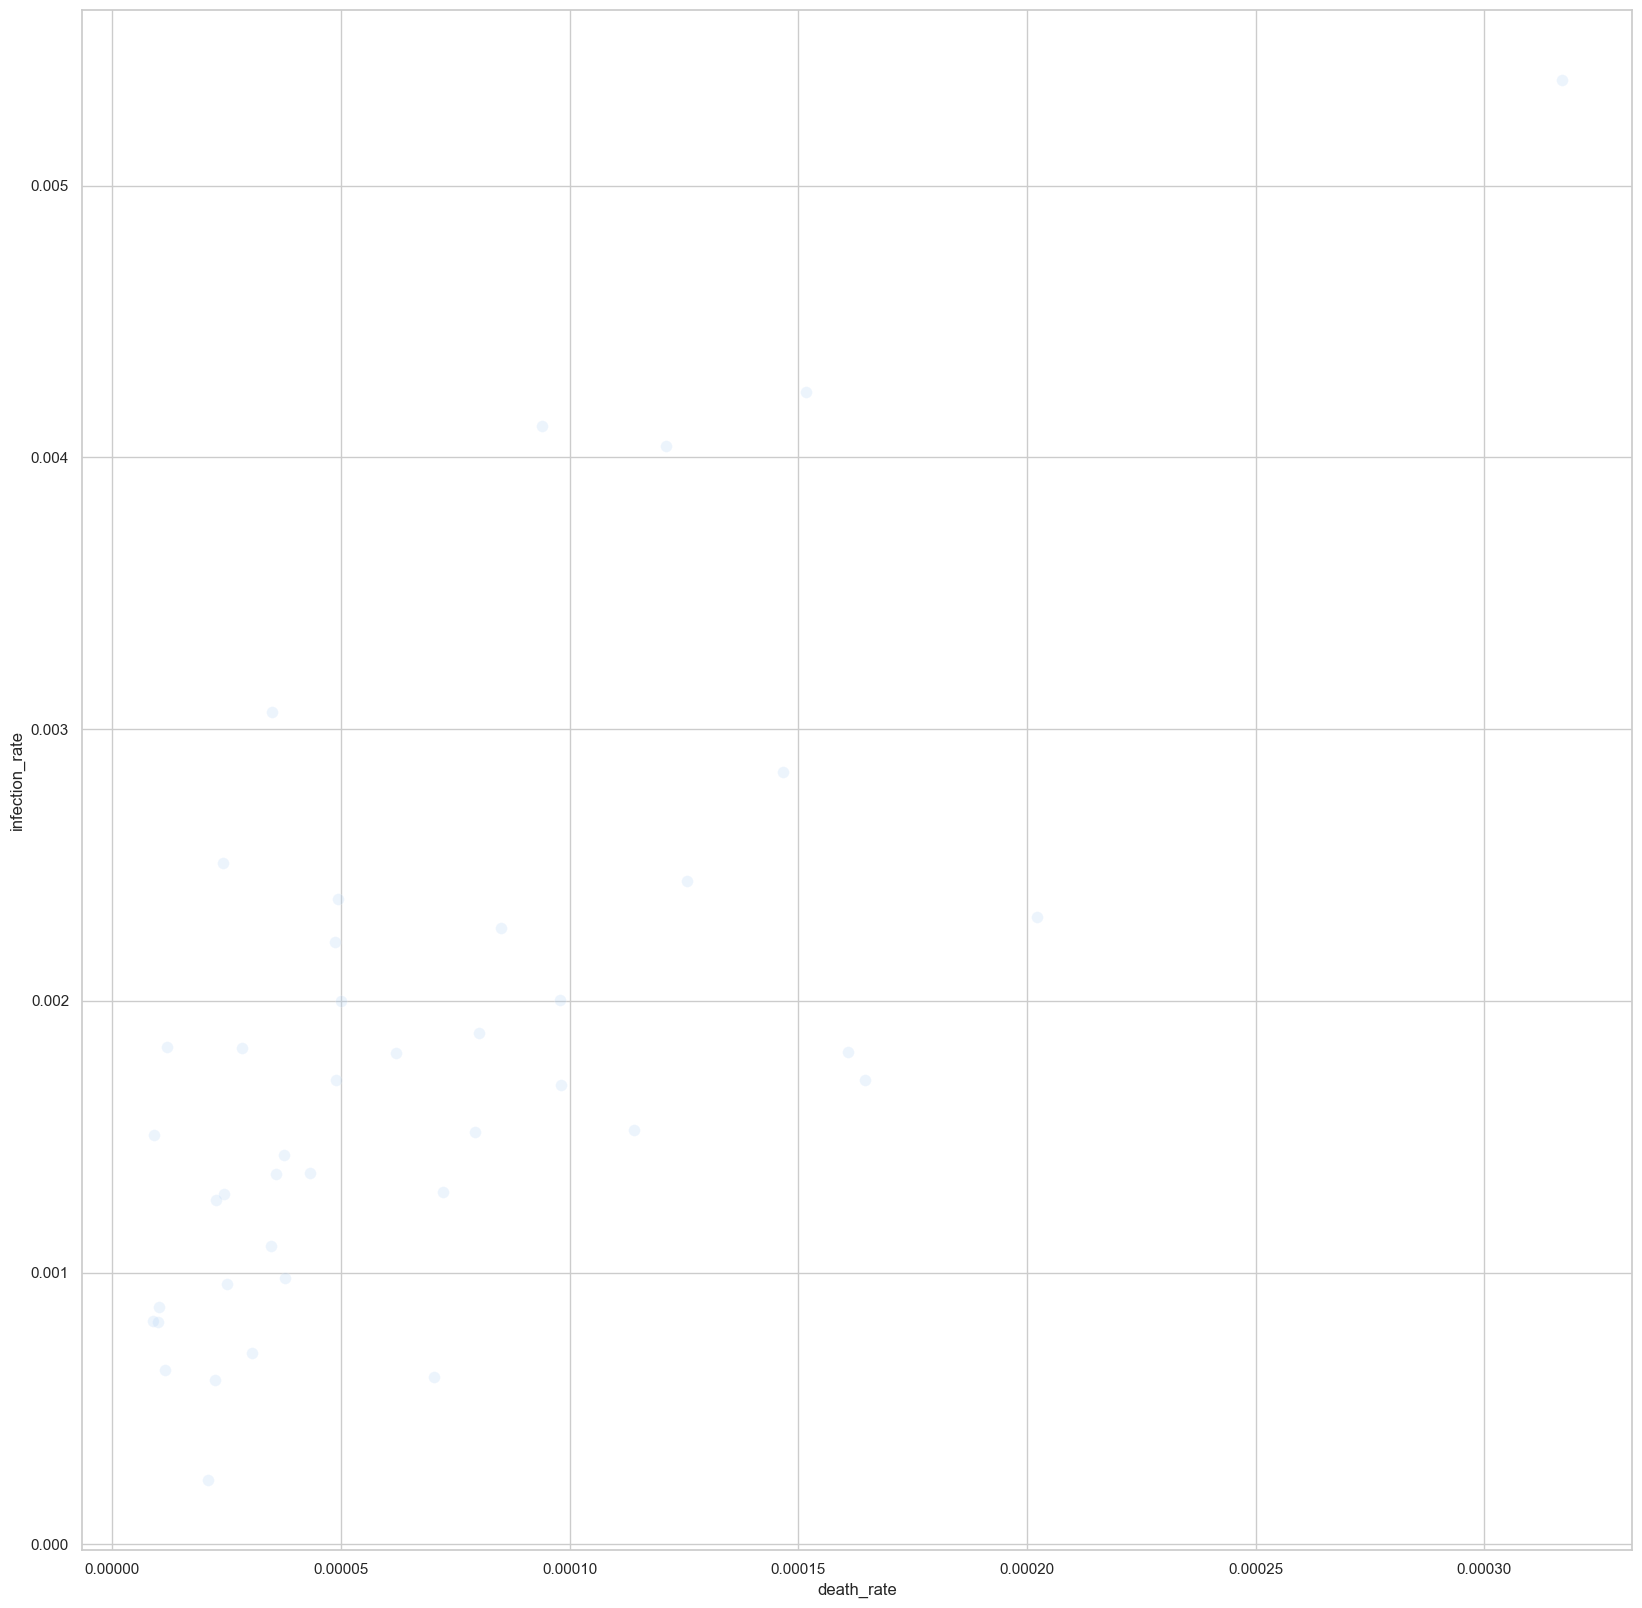

In [307]:
# Plot some scatterplots to better understand the data
sns.scatterplot(data=lhdi_active_pop_covid_fromdb, x="death_rate", y="infection_rate", alpha=0.2, s=70, legend=True)

<AxesSubplot: xlabel='lhdi_2018_pred', ylabel='infection_rate'>

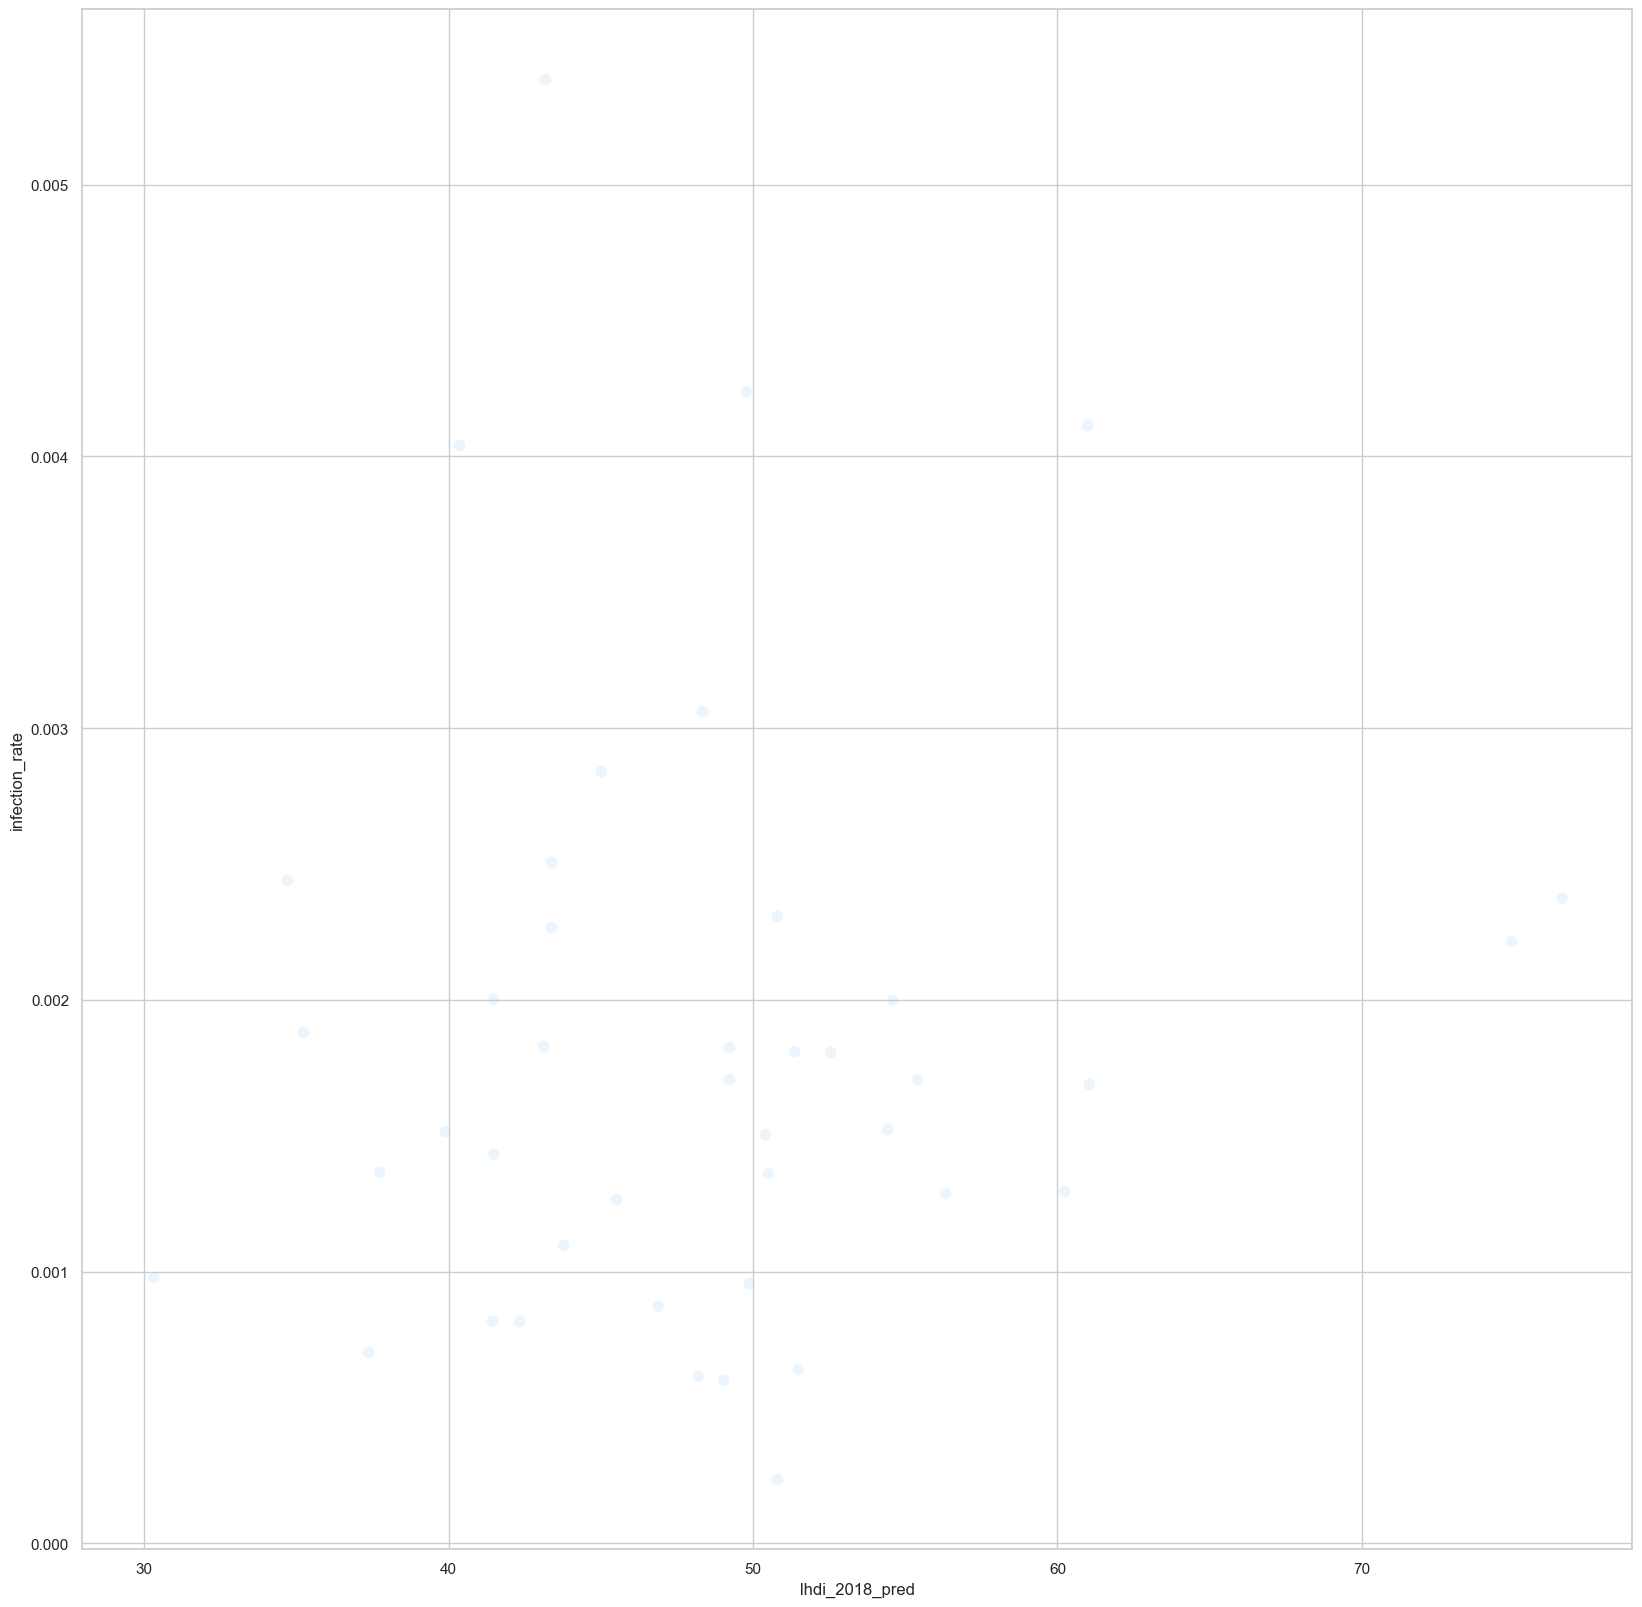

In [308]:
sns.scatterplot(data=lhdi_active_pop_covid_fromdb, x="lhdi_2018_pred", y="infection_rate", alpha=0.2, s=70, legend=True)

In [309]:
# Compute some logs
lhdi_active_pop_covid_fromdb['infection_rate_log'] = np.log(lhdi_active_pop_covid_fromdb['infection_rate'])
lhdi_active_pop_covid_fromdb['death_rate_log'] = np.log(lhdi_active_pop_covid_fromdb['death_rate'])
lhdi_active_pop_covid_fromdb['healed_rate_log'] = np.log(lhdi_active_pop_covid_fromdb['healed_rate'])
lhdi_active_pop_covid_fromdb.head()

C:\Users\scioban\Downloads\temp_projects\aidr-madc2022\aidr_venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,_id,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate,infection_rate_log,death_rate_log,healed_rate_log
0,6372ba841d2a4bcae664bd60,Alba,52.537216,370821,230414.0,AB,671,27,23,0.000062,0.001809,0.000073,0.621362,-6.314706,-9.687981,-9.527638
1,6372ba841d2a4bcae664bd61,Arad,55.393345,467718,291486.0,AR,799,1,77,0.000165,0.001708,0.000002,0.623209,-6.372260,-8.711815,-13.055621
2,6372ba841d2a4bcae664bd62,Arges,49.758516,626489,392185.0,AG,2656,0,95,0.000152,0.004239,0.000000,0.626005,-5.463310,-8.794010,-inf
3,6372ba841d2a4bcae664bd63,Bacau,39.872043,732530,465121.0,BC,1112,0,58,0.000079,0.001518,0.000000,0.634951,-6.490344,-9.443817,-inf
4,6372ba841d2a4bcae664bd64,Bihor,50.479208,614001,381766.0,BH,836,0,22,0.000036,0.001362,0.000000,0.621768,-6.599123,-10.236709,-inf


<AxesSubplot: xlabel='death_rate_log', ylabel='infection_rate_log'>

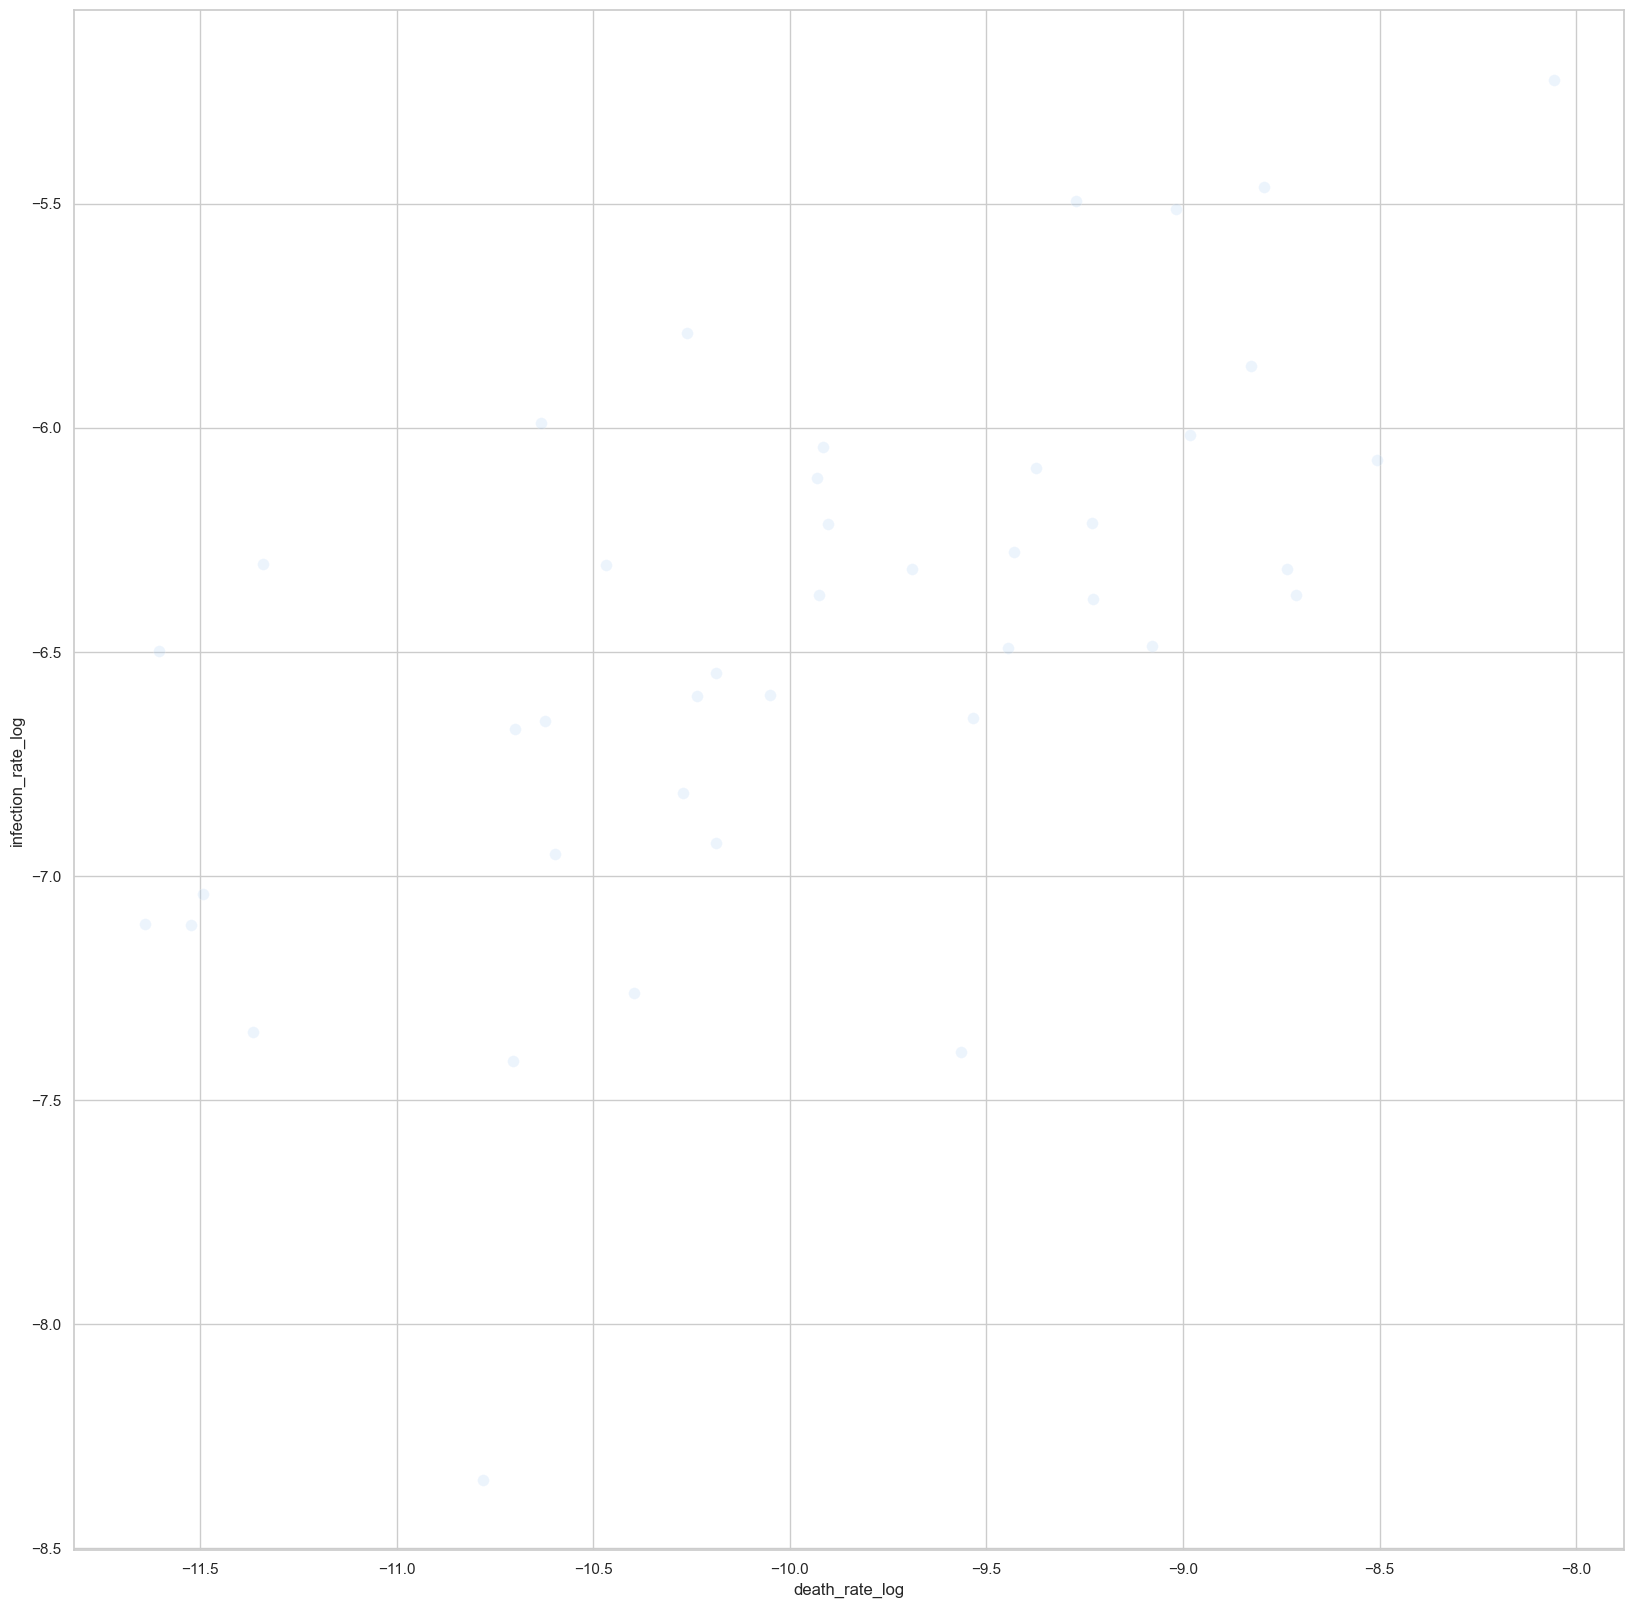

In [310]:
sns.scatterplot(data=lhdi_active_pop_covid_fromdb, x="death_rate_log", y="infection_rate_log", alpha=0.2, s=70,
                legend=True)

<AxesSubplot: xlabel='lhdi_2018_pred', ylabel='infection_rate_log'>

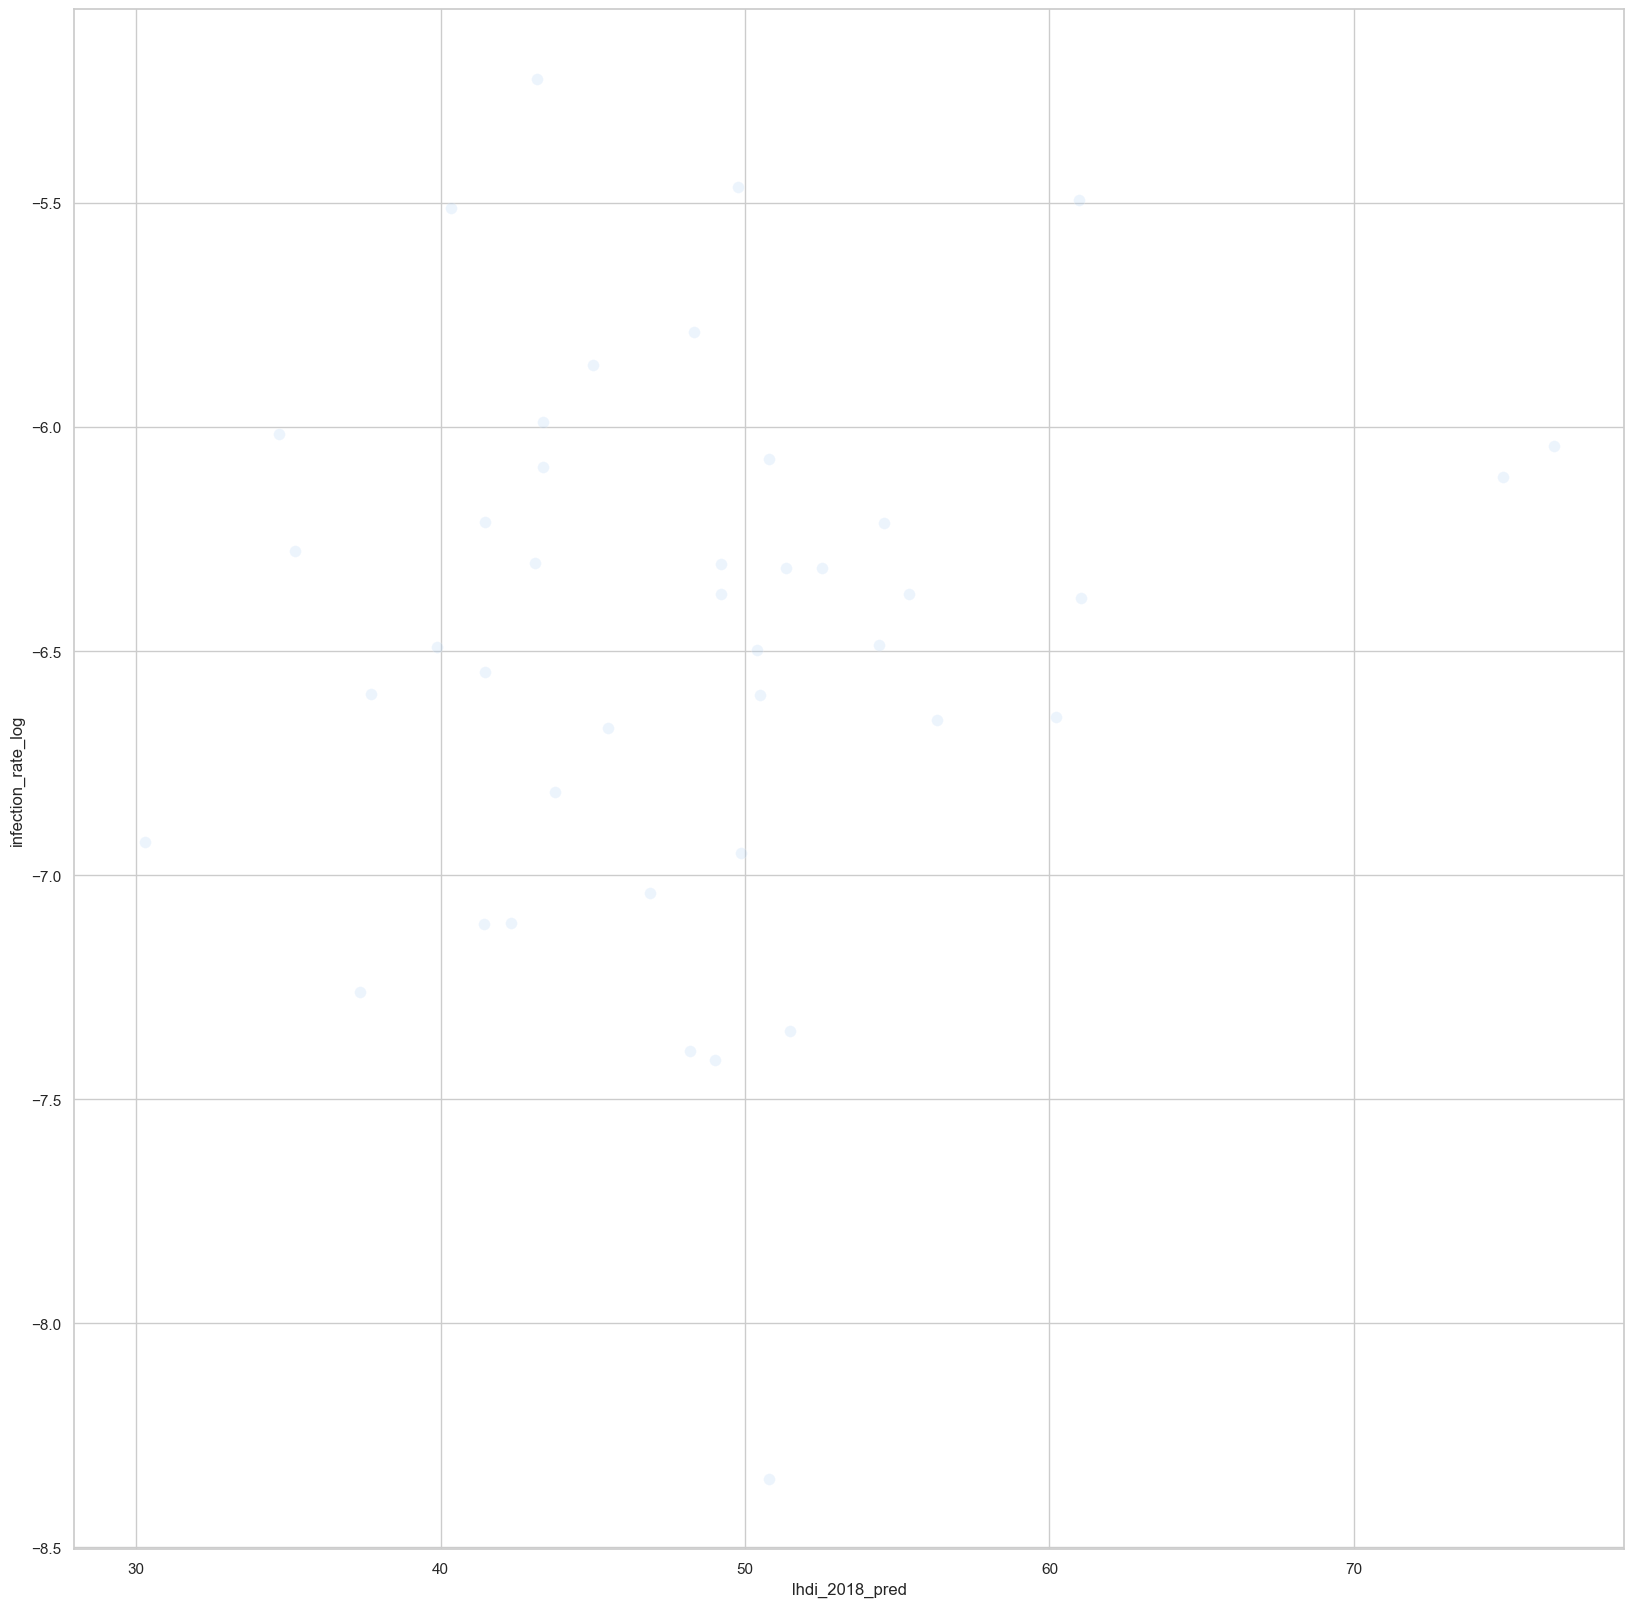

In [328]:
sns.scatterplot(data=lhdi_active_pop_covid_fromdb, x="lhdi_2018_pred", y="infection_rate_log", alpha=0.2, s=70,
                legend=True)

In [312]:
# Gather geospatial data on Romania's counties
geo_json_url = "https://raw.githubusercontent.com/geospatialorg/covid19/master/api/counties.geojson"

In [313]:
county_gdf = gpd.read_file(geo_json_url)
county_gdf.head(2)

,gid,county,county_code,x_cen,y_cen,geometry
0,1,BISTRIȚA-NĂSĂUD,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160..."
1,2,HUNEDOARA,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500..."


In [314]:
county_gdf.shape

(43, 6)

In [315]:
county_gdf.drop(columns=['county'], inplace=True)

In [316]:
county_gdf.rename(columns={'county_code': 'code'}, inplace=True)
county_gdf.head()

,gid,code,x_cen,y_cen,geometry
0,1,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160..."
1,2,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500..."
2,3,BT,2.979024e+06,6.083635e+06,"POLYGON ((3014542.940 6021798.540, 3014787.850..."
3,4,AR,2.421971e+06,5.824345e+06,"POLYGON ((2504120.810 5819440.400, 2503107.810..."
4,5,BR,3.080402e+06,5.635431e+06,"POLYGON ((3043040.730 5589823.640, 3040090.770..."


<AxesSubplot: >

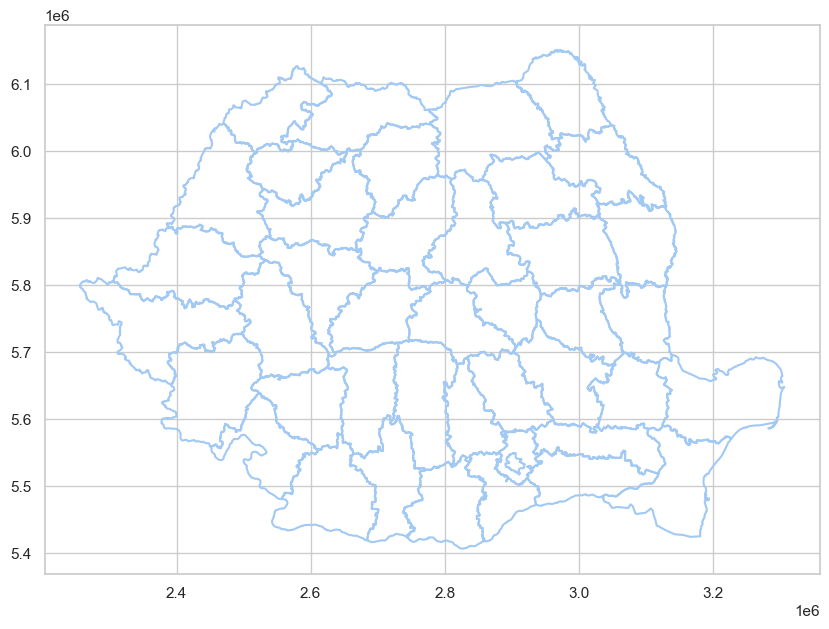

In [326]:
county_gdf.boundary.plot(figsize=(10, 10))

In [318]:
lhdi_active_pop_covid_fromdb = county_gdf.merge(lhdi_active_pop_covid_fromdb, on='code')
lhdi_active_pop_covid_fromdb.shape

(42, 20)

In [319]:
lhdi_active_pop_covid_fromdb.head()

,gid,code,x_cen,y_cen,geometry,_id,county,lhdi_2018_pred,total_pop,pop_age_18_62,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate,infection_rate_log,death_rate_log,healed_rate_log
0,1,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160...",6372ba841d2a4bcae664bd65,Bistrita-Nasaud,50.777222,326580,203812.0,754,0,66,0.000202,0.002309,0.000000,0.624080,-6.071038,-8.506775,-inf
1,2,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500...",6372ba841d2a4bcae664bd75,Hunedoara,51.358319,447761,282382.0,811,3,72,0.000161,0.001811,0.000007,0.630653,-6.313747,-8.735349,-11.913403
2,3,BT,2.979024e+06,6.083635e+06,"POLYGON ((3014542.940 6021798.540, 3014787.850...",6372ba841d2a4bcae664bd66,Botosani,34.692308,454026,286228.0,1109,3,57,0.000126,0.002443,0.000007,0.630422,-6.014696,-8.982858,-11.927297
3,4,AR,2.421971e+06,5.824345e+06,"POLYGON ((2504120.810 5819440.400, 2503107.810...",6372ba841d2a4bcae664bd61,Arad,55.393345,467718,291486.0,799,1,77,0.000165,0.001708,0.000002,0.623209,-6.372260,-8.711815,-13.055621
4,5,BR,3.080402e+06,5.635431e+06,"POLYGON ((3043040.730 5589823.640, 3040090.770...",6372ba841d2a4bcae664bd67,Braila,43.111364,336027,209509.0,615,0,4,0.000012,0.001830,0.000000,0.623489,-6.303325,-11.338652,-inf


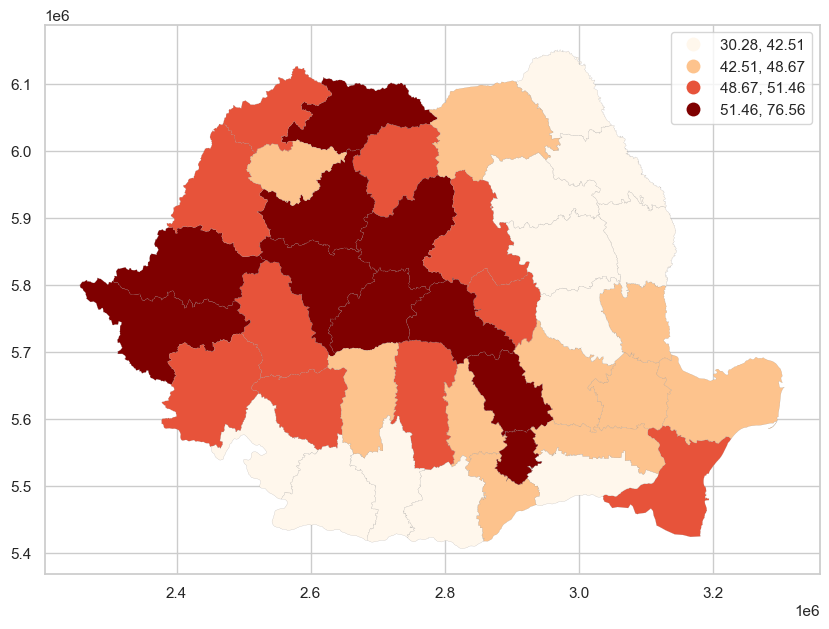

In [322]:
plt = lhdi_active_pop_covid_fromdb.plot(column=lhdi_active_pop_covid_fromdb['lhdi_2018_pred'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

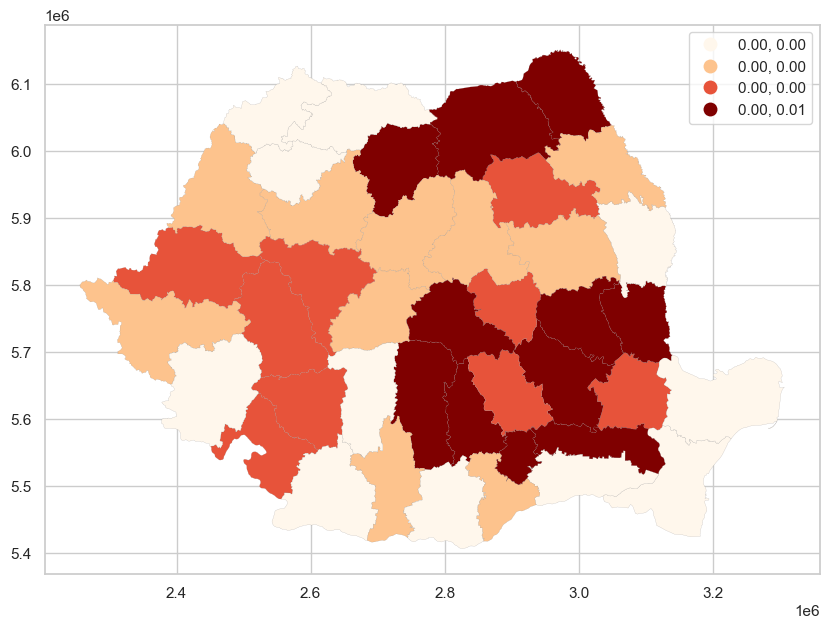

In [323]:
plt = lhdi_active_pop_covid_fromdb.plot(column=lhdi_active_pop_covid_fromdb['infection_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

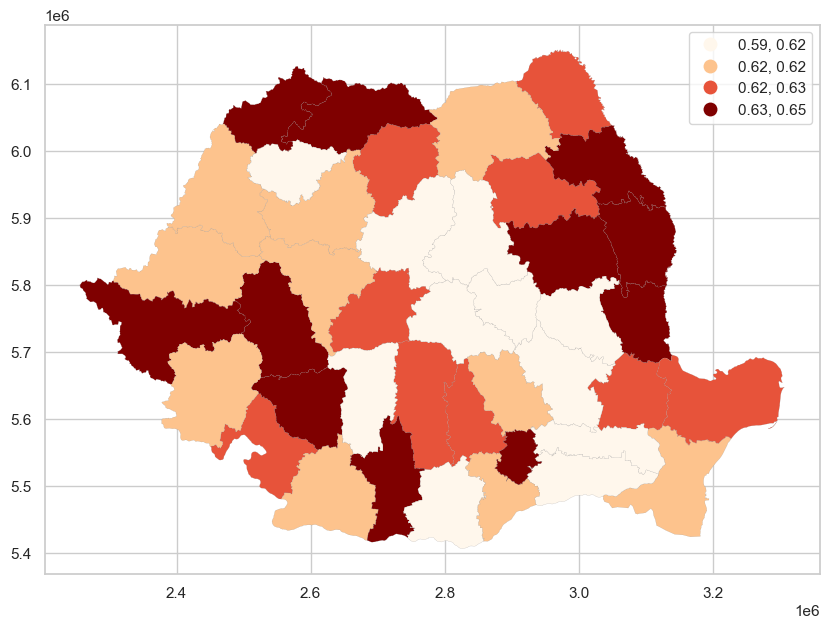

In [324]:
plt = lhdi_active_pop_covid_fromdb.plot(column=lhdi_active_pop_covid_fromdb['active_pop_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

C:\Users\scioban\Downloads\temp_projects\aidr-madc2022\aidr_venv\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\scioban\Downloads\temp_projects\aidr-madc2022\aidr_venv\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


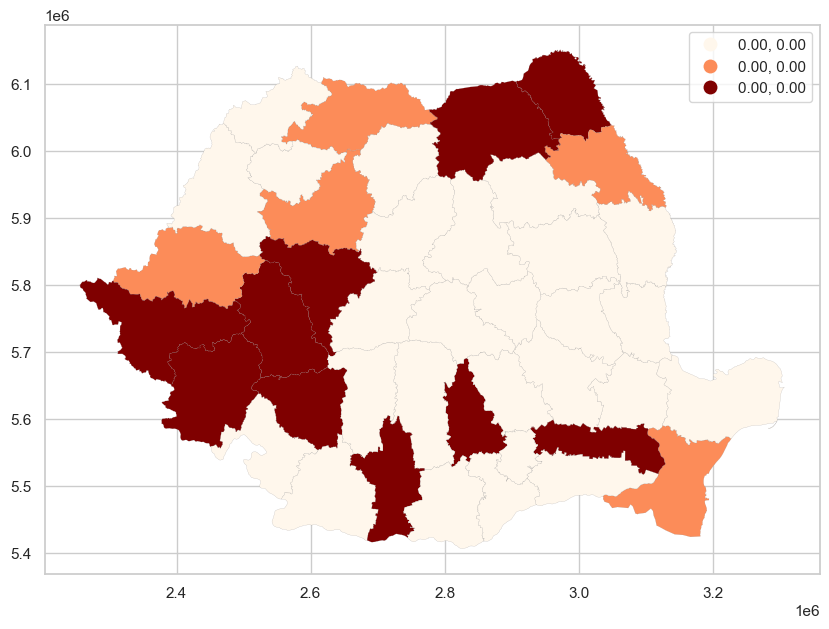

In [325]:
plt = lhdi_active_pop_covid_fromdb.plot(column=lhdi_active_pop_covid_fromdb['healed_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)